# Лабораторная 2: Классификатор

> Разработка простых классификаторов: _K-ближайших соседей_ и _наивный байесовский классификатор_.

Используемые библиотеки (включая собственные классификаторы):

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.naive_bayes     import MultinomialNB
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import OneHotEncoder

from scipy.stats import chi2_contingency

import classifiers.knn
import classifiers.bayes

data_folder = "data/" # Папка хранения данных

Далее лабораторная будет разделена на две части для каждого классификатора соответственно.

## Метод _K-ближайших соседей_

Метод _K-ближайших соседей_ описывает данные на основе их близости к `K` другим соседям. 
Так как высчитывается расстояние, проще всего работать с данными, особенности у которых - численные.
Существует множество разных методов для высчитывания расстояния (вплоть до косинусного коэффициента),
но для численных особенностей достаточно расстояние Евклида.

### Рассмотр данных

Для начала необходимо рассмотреть данные, с которsми будет проведена работа. 
[Характеристика красных вин и их оценка](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009)
является хорошим кандидатом, ввиду того, что все особенности там численные.

In [2]:
wines = pd.read_csv(data_folder + "winequality-red.csv")
wines

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Датасет предоставлен для обучения машины, способной создать идеальные химические пропорции для 
получения вина высшего качества, но в данном случае ее можно использовать для предсказания оценки
на основе известных данных (используя KNN).

Для начала проверим данные на наличие пустых ячеек и выбросов 
(хотя учитывая алгоритм, они не будут иметь сильного влияния):

In [3]:
wines.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [4]:
wines.agg(['min', 'max'])

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
min,4.6,0.12,0.0,0.9,0.012,1.0,6.0,0.99007,2.74,0.33,8.4,3
max,15.9,1.58,1.0,15.5,0.611,72.0,289.0,1.00369,4.01,2.00,14.9,8


В таблице нет ни одной пустой ячейки, и все данные расположены достаточно рядом за исключением "total sulfur dioxide". Рассмотрев её подробнее:

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1079,7.9,0.3,0.68,8.3,0.05,37.5,278.0,0.99316,3.01,0.51,12.3,7
1081,7.9,0.3,0.68,8.3,0.05,37.5,289.0,0.99316,3.01,0.51,12.3,7


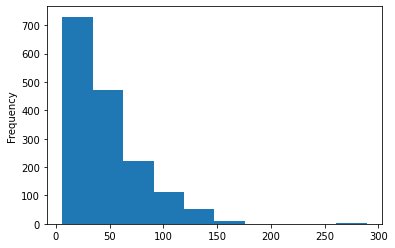

In [5]:
wines["total sulfur dioxide"].plot.hist()
wines.loc[wines["total sulfur dioxide"] > 200]

Видно, что две строки зашли дальше остальных. Эти строки можно исключить, но, так как алгоритм работает 
на близости соседей, а не на распределении, их можно игнорировать.

Рассмотрим корреляцию между особенностями и исключим те, которые имеют коэффициенты больше 0.5 (по модулю)

<AxesSubplot:>

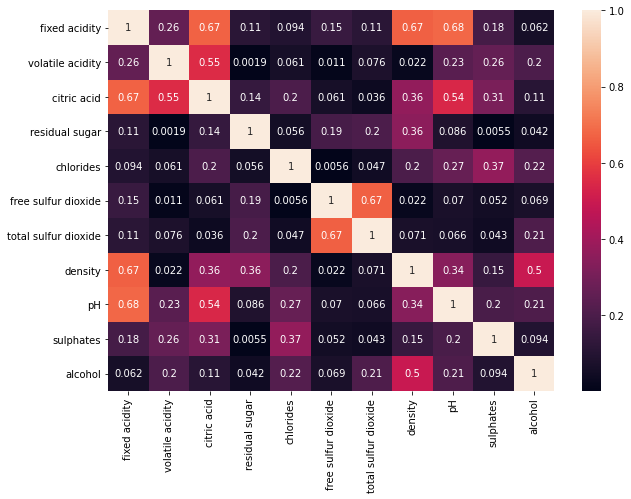

In [6]:
plt.subplots(figsize=(10, 7))
wines_corr = wines.iloc[:, :-1].corr().abs()
sns.heatmap(wines_corr, annot=True)

На графике видно, что пары `(0, 2), (0, 7), (0, 8), (1, 2), (2, 8) (5, 6), (7, 10)` имеют коэффициенты больше 0.5. Сама задача исключения особенности сводится к задаче исключения вершин на графе, имеющие наибольшее количество граней (если количество граней равны, то берем вершины с суммарной корреляцией, близкой к 0). Тогда исключаем особенности: `["fixed acidity", "citric acid", "total sulfur dioxide", "density"]`.

In [7]:
wines = wines.drop(columns=["fixed acidity", "citric acid", "total sulfur dioxide", "density"])

Для 1600 строк данных 6 классов возможно слишком много, поэтому их лучше сократить до двух - хороший (1) и плохой (0). Разбитие должно произойти так, чтобы их было максимально поровну:

<AxesSubplot:ylabel='Frequency'>

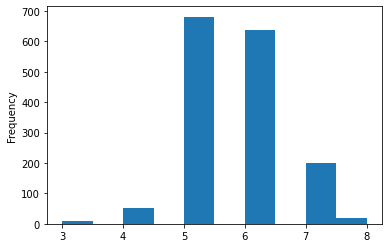

In [8]:
wines["quality"].plot.hist()

Значит пусть все, что меньше 6 - плохо, больше и равно - хорошо:

In [9]:
wines["quality"] = wines["quality"].apply(lambda x : 1 if x >= 6 else 0)
wines["quality"].value_counts()

1    855
0    744
Name: quality, dtype: int64

Столбец классов и столбцы особенностей необходимо отделить друг от друга:

In [10]:
X, y = wines.iloc[:, :-1], wines.iloc[:, -1]

### Использование классификатора

Так как у нас нет тестовых данных, придется разделить наши на две части: обучающие и тестовые - и преобразовать 
из таблицы в массивы

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3)

Отправим тренировочные данных в свой классификатор:

In [12]:
knn_1 = classifiers.knn.KNN(5)
knn_1.train(X_train, y_train)

Теперь можно попробовать классифицировать тренировочные данные:

In [13]:
%time y_predict = knn_1.predict(X_test)

CPU times: user 2.77 s, sys: 12 ms, total: 2.78 s
Wall time: 2.77 s


Полученный результат можно сравнить с реальными классами:

In [14]:
comp = (y_predict == y_test)
comp.sum() / comp.shape[0]

0.70625

Три запуска показали процент точности, близкий к 70, _в зависимости от того, как данные были разделены_. 
Те же данные можно использовать и для классификатора библиотеки `sklearn`: 

In [15]:
knn_2 = KNeighborsClassifier(5)
knn_2.fit(X_train, y_train)
%time y_predict = knn_2.predict(X_test)
comp = (y_predict == y_test)
comp.sum() / comp.shape[0]

CPU times: user 16.2 ms, sys: 2.01 ms, total: 18.2 ms
Wall time: 15.4 ms


0.70625

Который также показывает процент точности, близкий к 50, но имеет значительно большую скорость, так как
он пользуется предварительной обработкой данных для ускорения подсчета расстояния (собственная реализация
пользуется простой реализацией за квадратичное время).

## _Наивный байевский классификатор_

Вся идея байевского классификатора лежит в формуле Теореме Байеса:
$$
    P(c | x_1, x_2, ...) = \frac{P(c) P(x_1 | c) P(x_2 | c) ...}{P(x_1) P(x_2) ...}
$$
То есть вероятность класса $c$ в условиях особенностей $x_1, x_2, ...$ равна вероятности класса $c$ и 
вероятности особенностей $x_1, x_2, ...$ в условиях класса $c$, деленная на вероятность $x_1, x_2, ...$
независимо от класса. Так как мы сравниваем вероятности, делитель можно опустить.

В отличие от _K-ближайших соседей_, здесь не нужно вычислять расстояние и классификатор может принимать
и численные, так и словесные особенности, но для численных значений следует использовать другие методы
высчитывания вероятности, особенно если это значения с плавающей точкой

### Рассмотр данных

[Следующие данные](http://archive.ics.uci.edu/ml/datasets/Car+Evaluation) 
имеют особенности:

| Особенность | Возможные значения | Описание |
|:-:| :- | :- | 
| `buying`   | `vhigh, high, med, low` | Цена покупки
| `maint`    | `vhigh, high, med, low` | Стоимость обслуживания
| `doors`    | `2, 3, 4, 5more`        | Количество дверей
| `persons`  | `2, 4, more`            | Макс. количество пассажиров
| `lug_boot` | `small, med, big`       | Размер багажника
| `safety`   | `low, med, high`        | Оценочная безопасность

Задача состоит в предсказании оценки / приемлемости машины `eval` 

In [16]:
cars = pd.read_csv(data_folder + "cars/car.data")
cars

,buying,maint,doors,persons,lug_boot,safety,eval
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


Как всегда, нужно начинать с проверки на наличие пустых элементов таблицы:

In [17]:
cars.isnull().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
eval        0
dtype: int64

Пустых элементов нет.

Так как нам доступны все возможные значения для каждого столбца, 
далее стоит проверить наличие очепяток:

In [18]:
for column in cars:
    print(f"{column} unique values: ", sorted(cars[column].unique()))

buying unique values:  ['high', 'low', 'med', 'vhigh']
maint unique values:  ['high', 'low', 'med', 'vhigh']
doors unique values:  ['2', '3', '4', '5more']
persons unique values:  ['2', '4', 'more']
lug_boot unique values:  ['big', 'med', 'small']
safety unique values:  ['high', 'low', 'med']
eval  unique values:  ['acc', 'good', 'unacc', 'vgood']


Данные необходимо разделить на особенности и классы:

In [19]:
cars_X = cars.iloc[:, :-1]
cars_y = cars.iloc[:, -1]

С помощью $\phi$ функции Крамера проверяется коррелированность столбцов для особенностей, состоящих из категорий

In [20]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    n     = confusion_matrix.sum().sum()
    chi2 = chi2_contingency(confusion_matrix)[0]
    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    phi_corr = max(0, phi2 - ((k-1) * (r-1)) / (n-1))
    r_corr   = r - ((r-1)**2) / (n-1)
    k_corr   = k - ((k-1)**2) / (n-1)
    
    return np.sqrt( phi_corr / min((k_corr-1), (r_corr-1)) )

cram_size = cars_X.shape[1]
cars_corr = np.zeros((cram_size, cram_size))
for i in range(cram_size):
    for j in range(cram_size):
        cars_corr[i, j] = cramers_v(cars.iloc[:, i], cars.iloc[:, j])
        
cars_corr

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

Видно, что столбцы никак не коррелируют между собой

### Работа с данными

Данные были разделены раннее, но, так как нет тестовых данных, их разделяют еще раз:

In [21]:
X_train, X_test, y_train, y_test = train_test_split(cars_X.values, cars_y.values, test_size=0.3)

Данные классифицируются по такому же алгоритму:

In [22]:
bayes = classifiers.bayes.Bayes()
bayes.train(X_train, y_train)
%time y_predict = bayes.predict(X_test)
comp = (y_predict == y_test)
comp.sum() / comp.shape[0]

CPU times: user 9.77 ms, sys: 4.35 ms, total: 14.1 ms
Wall time: 12.3 ms


0.861271676300578

Собственный Байевский классификатор дает точность $84\%$. Для сравнения с `sklearn` необходимо 
закодировать данные в численный формат:

In [23]:
feats_encoder = OneHotEncoder()
X_train = feats_encoder.fit_transform(X_train)
X_test  = feats_encoder.transform(X_test)

Теперь, данные можно использовать для байевского классификатора. Наиболее похожий из доступных: `MultinomialNB`

In [24]:
# alpha используется для смягчения, 0 для работы схожей с собственным классификатором
mnb = MultinomialNB(alpha=0)
mnb.fit(X_train, y_train)
%time y_predict = mnb.predict(X_test)
comp = (y_predict == y_test)
comp.sum() / comp.shape[0]

CPU times: user 311 µs, sys: 102 µs, total: 413 µs
Wall time: 337 µs


/home/rookstar/Documents/venvs/machine_learning/lib/python3.9/site-packages/sklearn/naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '


0.861271676300578

Хотя если оставить коэффициент смягчения равным единице, то результат не изменится:

In [25]:
mnb = MultinomialNB(alpha=1)
mnb.fit(X_train, y_train)
%time y_predict = mnb.predict(X_test)
comp = (y_predict == y_test)
comp.sum() / comp.shape[0]

CPU times: user 132 µs, sys: 43 µs, total: 175 µs
Wall time: 179 µs


0.8554913294797688

Таким образом, наш классификатор хоть и медленнее, но дает тот же результат